In [1]:
%load_ext autoreload
%autoreload 2

import plotter
import analysis
import lmpsetup
import hmdsetup

import numpy as np
import matplotlib.pyplot as plt
import analysis

import mdtraj as md

## Summary

Ramon wants this week to be a recap of all thing we're currently doing. 

**[1. HPS-T implementation](#1)** : Review my implementation of the HPS-T model

**[2. Charge effect maximization](#2)** : From last week, even in HPS-T it seems that differences, at least in single chain which can easily propagate to multi-chain, are minimal, and so a reduction in hydrophobicity strength is required. The idea is to test whether the minimization-reweighting algorithm used before is enough.

**[3. HOOMD Build](#3)** : We suspect that HOOMD might be faster than LAMMPS. To check let's try if we can recreate the Rg's of CPEB4 using the program and then show a small performance of HOOMD for a droplet.

**[4. Slab Method](#4)** : Also, the slab method is more or less ready, and we can show this in some pictures. Maybe we can already build a phase diagram. We'll see.

**[5. TDP-43](#5)** : Plot the results of the TDP-43 mutagenesis with an hydrophobicity scale of 0.7

### 1. HPS-T implementation <a id='1'></a>

In [2]:
p = plotter.Plotter(data_dir='/home/adria/perdiux/prod/lammps/dignon')
p.index

,Protein,I,Eps,Scale,Name,FullPath
0,dignon,100,80.0,1.29,12D,/home/adria/perdiux/prod/lammps/dignon/CARLA-R...
1,dignon,100,80.0,1.29,7D,/home/adria/perdiux/prod/lammps/dignon/CARLA-R...
2,dignon,100,80.0,1.29,D4,/home/adria/perdiux/prod/lammps/dignon/CARLA-R...
3,dignon,100,80.0,1.29,WT,/home/adria/perdiux/prod/lammps/dignon/CARLA-R...
4,dignon,100,80.0,1.00,12D,/home/adria/perdiux/prod/lammps/dignon/CARLA-R...
...,...,...,...,...,...,...
61,dignon,100,80.0,1.00,NORMAL,/home/adria/perdiux/prod/lammps/dignon/SLAB-TE...
62,dignon,100,80.0,1.00,NORMAL-PAD,/home/adria/perdiux/prod/lammps/dignon/SLAB-TE...
63,dignon,100,80.0,1.00,WT-NONREX,/home/adria/perdiux/prod/lammps/dignon/T-DIFF/...
64,dignon,100,80.0,1.00,WT-REX,/home/adria/perdiux/prod/lammps/dignon/T-DIFF/...


> Run Completed at 67.18% for CspTm. Ran 1343590000 steps for a total of 268719 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
> Run Completed at 100.00% for Integrase. Ran 2000000000 steps for a total of 400001 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations


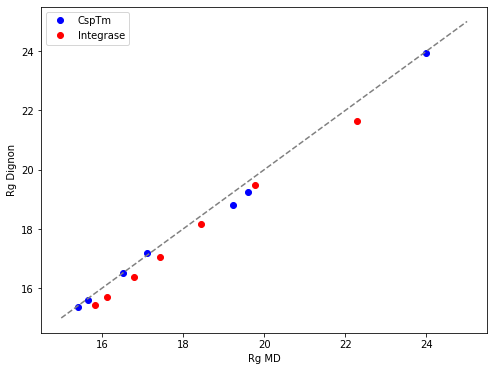

In [11]:
# CspTm
rg_csp_lmp = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/CspTm').rg().mean(axis=1)
rg_int_lmp = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/Integrase').rg().mean(axis=1)
rg_csp_exp = np.genfromtxt('/home/adria/documents/csp.txt')
rg_int_exp = np.genfromtxt('/home/adria/documents/integrase.txt')
plt.figure(figsize=(8,6))
plt.xlabel("Rg MD")
plt.ylabel("Rg Dignon")
plt.plot(rg_csp_lmp, rg_csp_exp[:,1]*10.,'bo', label='CspTm')
plt.plot(rg_int_lmp, rg_int_exp[:,1]*10.,'ro', label='Integrase')
plt.plot(np.linspace(15,25,1000),np.linspace(15,25,1000),'--', color='grey')
plt.legend()

> Run Completed at 100.00% for Integrase. Ran 2000000000 steps for a total of 400001 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
(7, 10000)


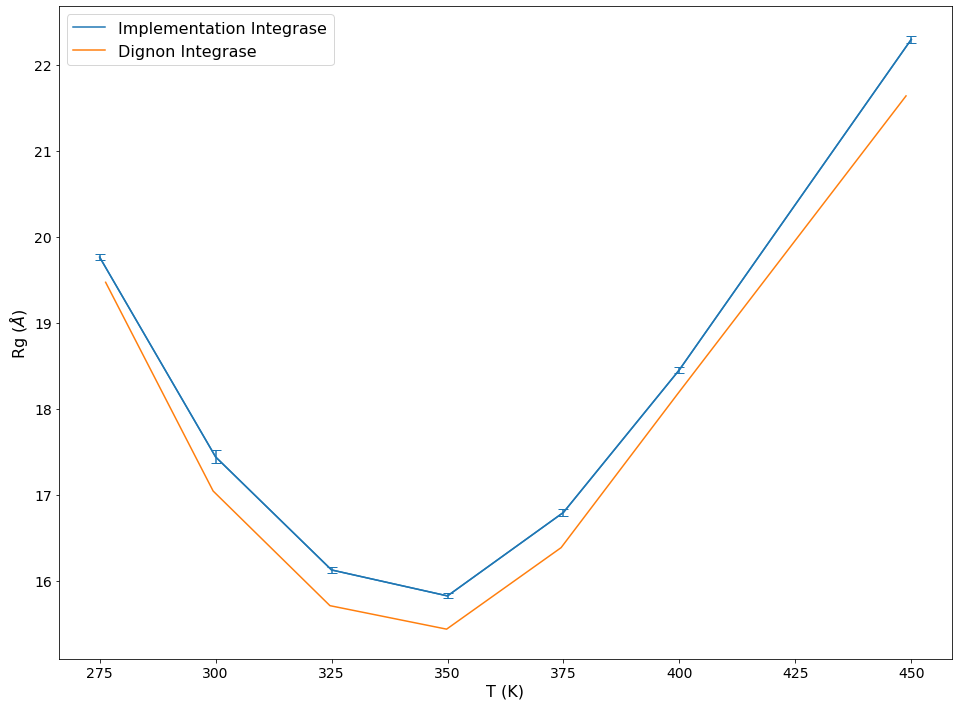

In [108]:
# Integrase

rg_T = []
rg = p.plot(observable='rg', index=33, plot_id='rg_integrase', label='Implementation Integrase')
rg_exp = np.genfromtxt('/home/adria/documents/integrase.txt')
p.plots['rg_integrase'][1].plot(rg_exp[:,0], rg_exp[:,1]*10, label='Dignon Integrase')
p.plots['rg_integrase'][1].legend(fontsize=16)

### 2. Charge effect maximization <a id='2'></a>

Recall that for a single chain, our constructs' radius of gyration where **almost equal** at all temperatures :

In [3]:
p = plotter.Plotter(data_dir='/home/adria/perdiux/prod/lammps/dignon')

> Run Completed at 21.91% for 12D_CPEB4_D4. Ran 219050000 steps for a total of 43811 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
(7, 10000)
> Run Completed at 14.38% for 7D_CPEB4. Ran 143805000 steps for a total of 28762 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
(7, 10000)
> Run Completed at 31.77% for CPEB4. Ran 317695000 steps for a total of 63540 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
(7, 10000)
> Run Completed at 38.98% for CPEB4_D4. Ran 389850000 steps for a total of 77971 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
(7, 10000)


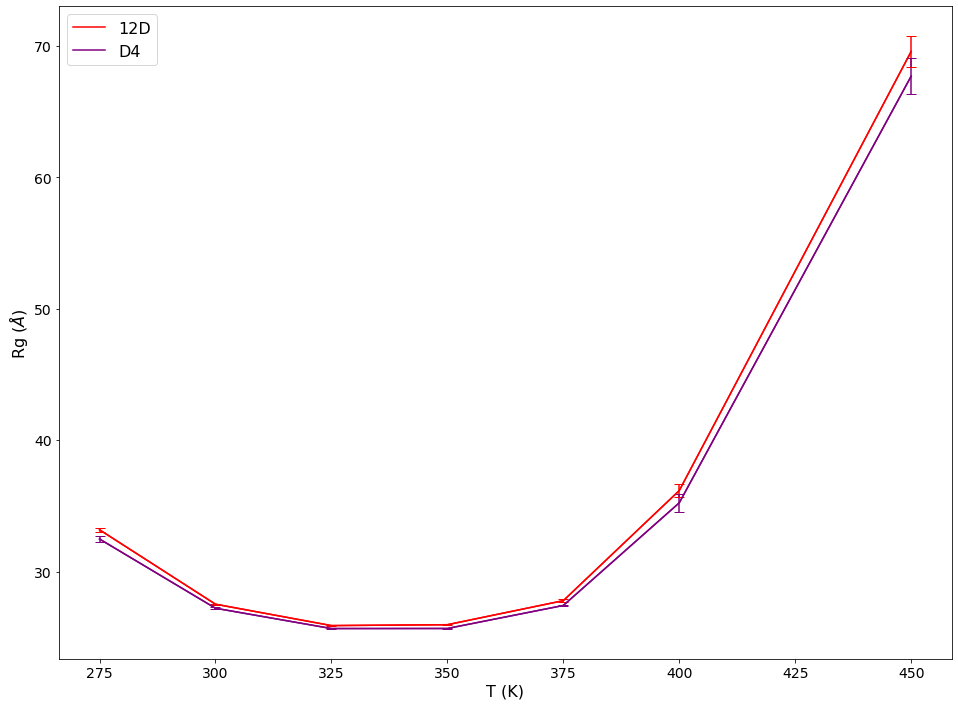

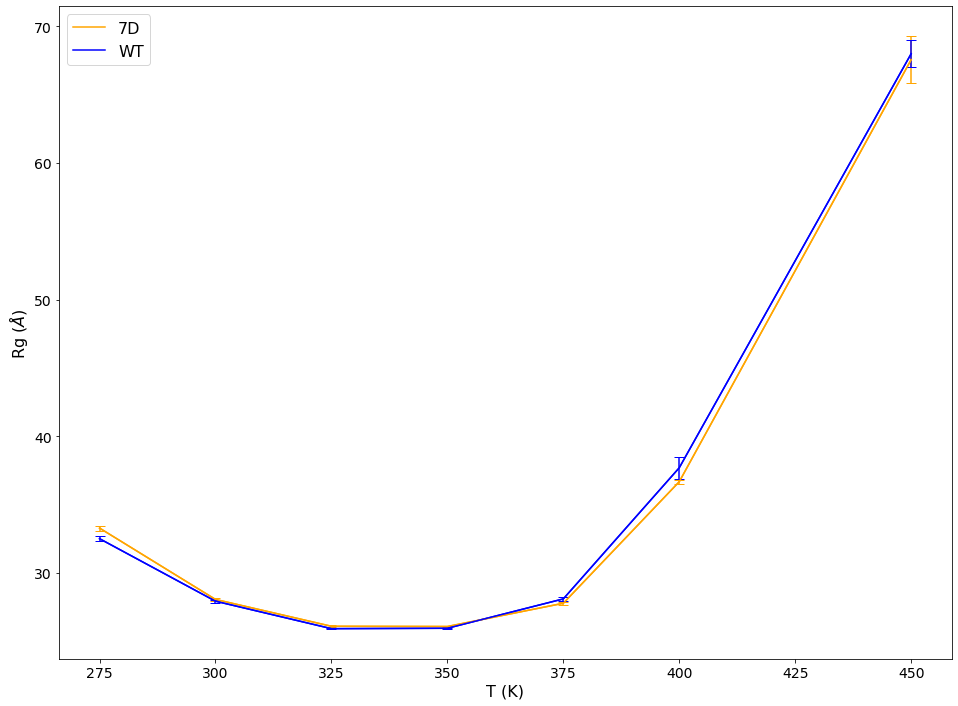

In [4]:
rg = p.plot(observable='rg', index=22, plot_id='d4', label='12D', color='red')
rg = p.plot(observable='rg', index=24, plot_id='wt', label='7D', color='orange')
rg = p.plot(observable='rg', index=26, plot_id='wt', label='WT', color='blue')
rg = p.plot(observable='rg', index=27, plot_id='d4', label='D4', color='purple')

Let's attempt the minimization !

In [16]:
path_12D = p.index.iloc[22]["FullPath"]
path_D4 = p.index.iloc[27]["FullPath"]

maxx = analysis.Analysis(oliba_wd=None)
maxx.maximize_charge(a_dir=path_12D, b_dir=path_D4, l0=0.97, T=2)

**It actually fails since the box is too small...**

### 3. HOOMD build <a id='3'></a>

Start by replicating the potentials : 

> Run Completed at 100.00% for None. Ran 2000 steps for a total of 2001 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
(2001, 2, 3)
(1, 2001, 8)
0.8000001


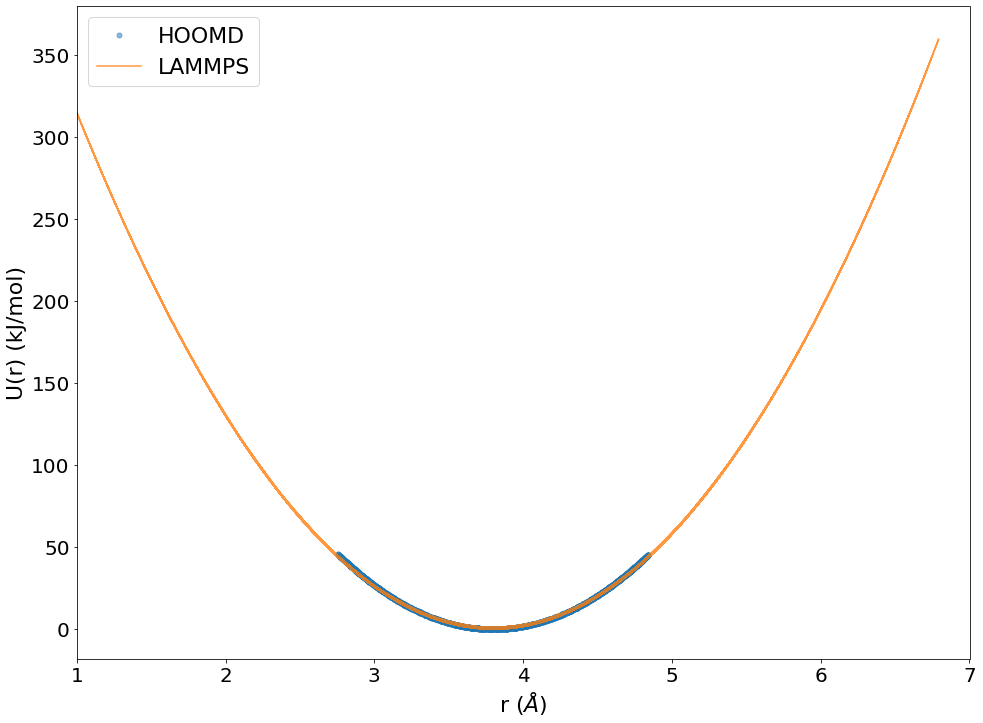

In [165]:
#LAMMPS
s = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HMDvsLMP/HARMTEST', equil_frames=0)
plt.figure(figsize=(16,12))
print(s.structures[0].xyz.shape)
print(s.data.shape)
plt.xlim(1,7)
d = np.linalg.norm(s.structures[0].xyz[:,0,:]-s.structures[0].xyz[:,1,:], axis=1)*10.
print(d[0])


import scipy.constants as cnt
import math

# HOOMD
tr = md.load('/home/adria/irb/prod/harmtest/trajectory_300.dcd', top='/home/adria/irb/prod/harmtest/topo.pdb')
dh = np.linalg.norm(tr.xyz[:,0,:]-tr.xyz[:,1,:], axis=1)*100.
plt.xlim(1,7)
with open('/home/adria/irb/prod/harmtest/log_300.log', 'r') as log:
    l = log.readlines()[1:]
data = np.genfromtxt(l)

plt.tick_params(labelsize=20)
plt.xlabel("Temperature (K)",fontsize=22)
plt.ylabel("Rg ($\AA$)",fontsize=22)
plt.ylabel("U(r) (kJ/mol)")
plt.xlabel("r ($\AA$)")
plt.plot(dh[:], data[:,1], '.', label='HOOMD', markersize=10, alpha=0.5)
plt.plot(d[:], s.data[0,:,1]*4.184, label='LAMMPS', lw=1.5, alpha=0.8)
plt.legend(fontsize=22)

> Run Completed at 100.00% for None. Ran 2000 steps for a total of 2001 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
(2001, 2, 3)
(1, 2001, 8)
4.5
1.3592640863388196e-20
4.8


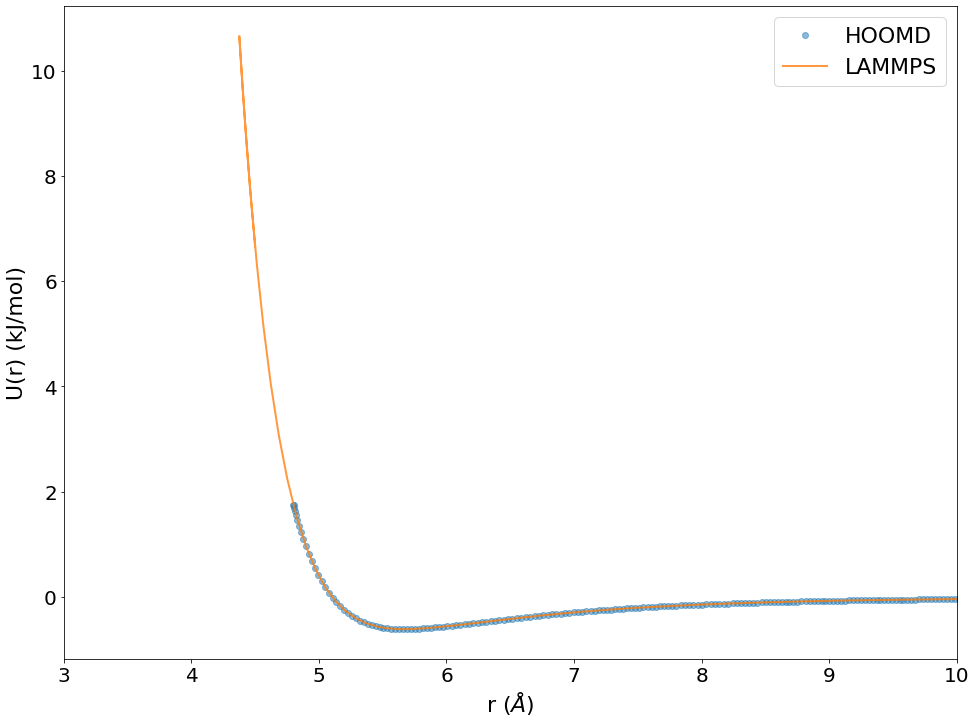

In [160]:
#LAMMPS
s = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HMDvsLMP/LJTEST', equil_frames=0)
plt.figure(figsize=(16,12))
print(s.structures[0].xyz.shape)
print(s.data.shape)
plt.xlim(3,10)
d = np.linalg.norm(s.structures[0].xyz[:,0,:]-s.structures[0].xyz[:,1,:], axis=1)*10.
print(d[0])


import scipy.constants as cnt
import math

print(math.sqrt(4*math.pi*cnt.epsilon_0*10**-9*10**3/cnt.Avogadro))
# HOOMD
tr = md.load('/home/adria/irb/prod/ljtest/trajectory_300.dcd', top='/home/adria/irb/prod/ljtest/topo.pdb')
dh = np.linalg.norm(tr.xyz[:,0,:]-tr.xyz[:,1,:], axis=1)*100.
print(dh[0])
plt.xlim(3,10)
with open('/home/adria/irb/prod/ljtest/log_300.log', 'r') as log:
    l = log.readlines()[1:]
data = np.genfromtxt(l)

plt.tick_params(labelsize=20)
plt.xlabel("Temperature (K)",fontsize=22)
plt.ylabel("Rg ($\AA$)",fontsize=22)
plt.ylabel("U(r) (kJ/mol)")
plt.xlabel("r ($\AA$)")
plt.plot(dh[:], data[:,1], '.', label='HOOMD', markersize=12, alpha=0.5)
plt.plot(d[:], s.data[0,:,1]*4.184, label='LAMMPS', lw=2, alpha=0.8)
plt.legend(fontsize=22)

> Run Completed at 100.00% for None. Ran 2000 steps for a total of 2001 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
(2001, 2, 3)
(1, 2001, 8)
4.8
1.3592640863388196e-20
4.8


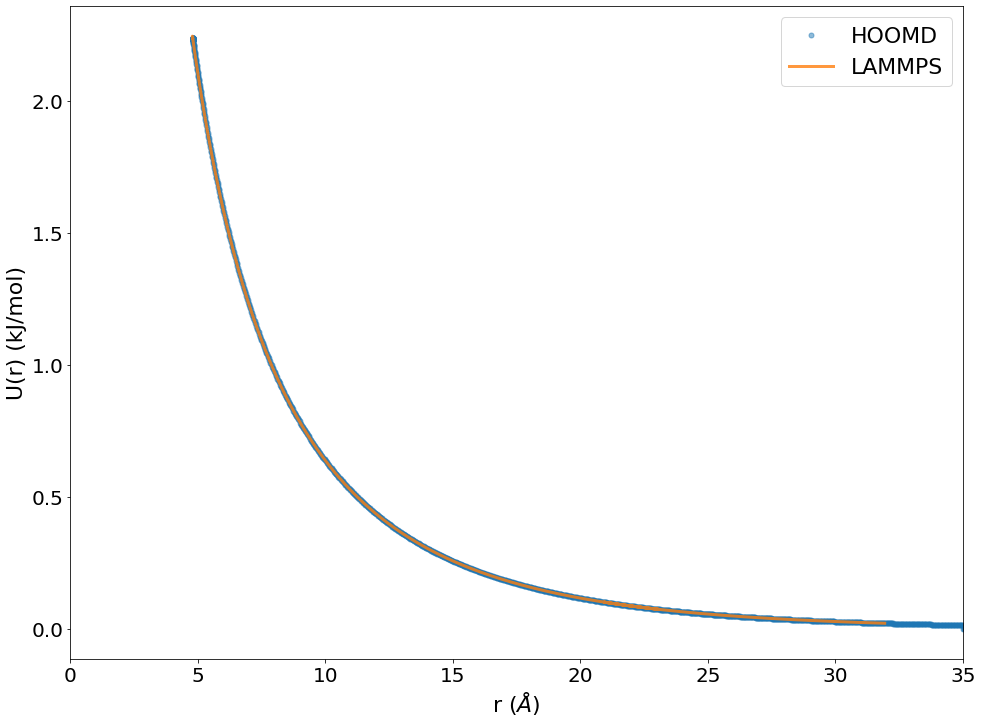

In [163]:
#LAMMPS
s = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HMDvsLMP/QTEST', equil_frames=0)
plt.figure(figsize=(16,12))
print(s.structures[0].xyz.shape)
print(s.data.shape)
plt.xlim(0,35)
d = np.linalg.norm(s.structures[0].xyz[:,0,:]-s.structures[0].xyz[:,1,:], axis=1)*10.
print(d[0])


import scipy.constants as cnt
import math

print(math.sqrt(4*math.pi*cnt.epsilon_0*10**-9*10**3/cnt.Avogadro))
# HOOMD
tr = md.load('/home/adria/irb/prod/qtest/trajectory_300.dcd', top='/home/adria/irb/prod/ljtest/topo.pdb')
dh = np.linalg.norm(tr.xyz[:,0,:]-tr.xyz[:,1,:], axis=1)*100.
print(dh[0])
plt.xlim(0,35)
with open('/home/adria/irb/prod/qtest/log_300.log', 'r') as log:
    l = log.readlines()[1:]
data = np.genfromtxt(l)

plt.tick_params(labelsize=20)
plt.xlabel("Temperature (K)",fontsize=22)
plt.ylabel("Rg ($\AA$)",fontsize=22)
plt.ylabel("U(r) (kJ/mol)")
plt.xlabel("r ($\AA$)")
plt.plot(dh[:], data[:,1], '.', label='HOOMD', markersize=10, alpha=0.5)
plt.plot(d[:], s.data[0,:,1]*4.184, label='LAMMPS', lw=3, alpha=0.8)
plt.legend(fontsize=22)

HPS was replicated in another notebook and it seemed just fine! Let's try to reproduce CPEB4 single chaing rg. Set it up using the new hmdsetup library :

In [197]:
temperatures = [300., 354.55, 390.91, 427.27]
for temp in temperatures:
    hmdsetup.HMDSetup(protein='CPEB4', 
                      oliba_wd='/home/adria/irb/prod/test', 
                      chains=1, 
                      save=5000,
                      box_size=200,
                      t=int(1e9),
                      temperature=temp).write_hps_files()

In [117]:
lmpsetup.LMPSetup(protein='CPEB4', 
                  oliba_wd='/home/adria/perdiux/all_test', 
                  chains=1, 
                  save=5000,
                  box_size=2000,
                  t=int(1e9),
                  temper=False,
                  temperatures=[300]).write_hps_files()

╔═══════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/all_test for CPEB4     ║
║-----------------------------------------------------------------------║
║   PARAMETERS                                                          ║
║       - Model = HPS                                                   ║
║       - Chains = 1                                                    ║
║       - Ionic Strength (mM) = 0.1                                     ║
║       - Medium Permittivity = 80.0                                    ║
║       - Temperatures (K) = [300]                                      ║
║       - HPS Scale = 1.0                                               ║
╚═══════════════════════════════════════════════════════════════════════╝


In [211]:
temperatures = [300., 354.55, 390.91, 427.27]
trs = []
rgs = []
plt.figure(figsize=(16,12))
for temp in temperatures:
    tr = md.load(f'/home/adria/irb/prod/test/trajectory_{temp:.0f}.dcd', top='/home/adria/irb/prod/test/topo.pdb')
    rg = md.compute_rg(tr).mean()*100.
    rgs.append(rg)
    

t = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/CPEB4/x1/1.0ls-100I-80e')
rgs_lmp = t.rg().mean(axis=1)

plt.tick_params(labelsize=16)
plt.xlabel("Temperature (K)",fontsize=18)
plt.ylabel("Rg ($\AA$)",fontsize=18)

plt.plot(temperatures, rgs, '--o', label='HOOMD')
plt.plot(t.temperatures, rgs_lmp, label='LAMMPS')
plt.legend(fontsize=22)

OSError: No such file: /home/adria/irb/prod/test/trajectory_427.dcd

<Figure size 1152x864 with 0 Axes>

In [224]:
temperatures = [300., 354.55, 390.91]
trs = []
rgs = []
plt.figure(figsize=(16,12))
for temp in temperatures:
    tr = md.load(f'/home/adria/irb/prod/test/trajectory_{temp:.0f}.dcd', top='/home/adria/irb/prod/test/topo.pdb')
    rg = md.compute_rg(tr).mean()*100.
    rgs.append(rg)
    

t = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/CPEB4/x1/1.0ls-100I-80e')
rgs_lmp = t.rg().mean(axis=1)

plt.tick_params(labelsize=16)
plt.xlabel("Temperature (K)",fontsize=18)
plt.ylabel("Rg ($\AA$)",fontsize=18)

plt.plot(temperatures, rgs, '--o', label='HOOMD')
plt.plot(t.temperatures, rgs_lmp, label='LAMMPS')
plt.legend(fontsize=22)

OSError: No such file: /home/adria/irb/prod/test/topo.pdb

<Figure size 1152x864 with 0 Axes>

Let's look at the energies...

> Run Completed at 0.00% for None. Ran 37750 steps for a total of 756 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


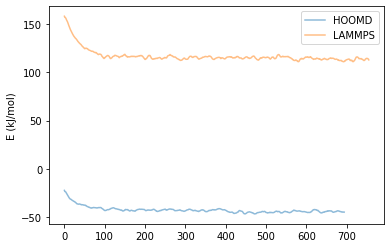

In [250]:
# HOOMD DATA
import os

hmd_dir = '/home/adria/irb/prod/HMDvsLMP/all_test'
with open(os.path.join(hmd_dir,'log_300.log'), 'r') as log:
    l = log.readlines()[1:]
hmd_data = np.genfromtxt(l)

# LAMMPS DATA
lmp = analysis.Analysis(oliba_wd='/home/adria/perdiux/all_test/test1', equil_frames=0)
E_HMD = hmd_data[:,1]+hmd_data[:,2]
E_LMP = (lmp.data[0,:,1]+lmp.data[0,:,2])*4.184
plt.plot(E_HMD, label='HOOMD', alpha=0.5)
plt.plot(E_LMP, label='LAMMPS', alpha=0.5)
plt.ylabel("E (kJ/mol)")
plt.legend()

> Run Completed at 0.03% for CPEB4. Ran 305600 steps for a total of 6113 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


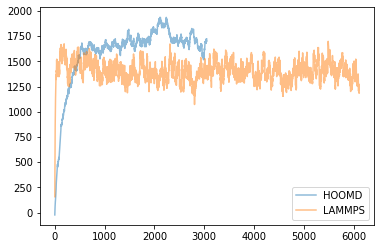

In [207]:
# HOOMD DATA
import os

hmd_dir = '/home/adria/irb/prod/all_test'
with open(os.path.join(hmd_dir,'log_300.log'), 'r') as log:
    l = log.readlines()[1:]
hmd_data = np.genfromtxt(l)

# LAMMPS DATA
lmp = analysis.Analysis(oliba_wd='/home/adria/perdiux/all_test', equil_frames=0)
plt.plot(hmd_data[:,1]+hmd_data[:,2], label='HOOMD', alpha=0.5)
plt.plot((lmp.data[0,:,1]+lmp.data[0,:,2])*4.184, label='LAMMPS', alpha=0.5)
plt.legend()

Regarding velocity, a single simulation at T=300K for single chain CPEB4 with HPS-T:

    - LAMMPS at 4 procs (optimal): 234 ts/s

    - HOOMD at 1 GPU (optimal) : 830 ts/s

A better benchmark, comparing GPU cases :

In [58]:
# Single chain

hmdsetup.HMDSetup(protein='CPEB4', 
                  oliba_wd='/home/adria/irb/prod/benchmark/sc/hmd', 
                  chains=1, 
                  save=500,
                  box_size=200,
                  t=int(10000),
                  temperature=300).write_hps_files()

# Droplet 

hmdsetup.HMDSetup(protein='CPEB4', 
                  oliba_wd='/home/adria/irb/prod/benchmark/droplet/hmd', 
                  chains=50, 
                  save=500,
                  box_size=200,
                  topo_path='/home/adria/irb/prod/benchmark/droplet/topo.pdb',
                  t=int(10000),
                  temperature=300).write_hps_files()

| GPU Runs |  HOOMD (HPS) | LAMMPS (LJ) | HOOMD (LJ)|
| :---: | :---: |  :---: | :---: |
| Single Chain (ts/s) |  929 | 4868 | 3700 | 
| Droplet (ts/s) |  70 |  187 | ? |

### 4. Slab Method <a id='4'></a>

Slab was too small, and so we didn't have an actual 2 phase but a droplet in a super small box. To optimize this, let's do it only for 12D at a "low" temperature and at a very high one to see how fast it dissolves. After all, it was too soon to generate an actual phase diagram...

In [88]:
wt = lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/CPEB4x50', 
                      protein='CPEB4', 
                      temper=False, 
                      chains=50, 
                      host='@perdiu35',
                      model='HPS-T',
                      debye=0.1,
                      use_random=True,
                      slab=True,
                      save=50000)
wt.temperatures = [300, 400, 500, 600]
wt.processors = 4
wt.t = 1000000000
wt.write_hps_files(silent=True)

In [79]:
d12 = lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/12D_CPEB4_D4x50', 
                       protein='12D_CPEB4_D4', 
                       temper=False, 
                       chains=50, 
                       model='HPS-T',
                       host='@perdiu39',
                       debye=0.1,
                       use_random=True,
                       slab=True,
                      save=50000)
d12.temperatures = [300, 400, 500, 600]
d12.processors = 4
d12.t = 1000000000
d12.write_hps_files(silent=True)

In [80]:
d7 = lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/7D_CPEB4x50', 
                      protein='7D_CPEB4', 
                      temper=False, 
                      chains=50, 
                      model='HPS-T',
                      host='@perdiu40',
                      slab=True,
                      debye=0.1,
                      use_random=True, 
                      save=50000)
d7.temperatures = [300, 400, 500, 600]
d7.processors = 4
d7.t = 1000000000
d7.write_hps_files(silent=True)

In [81]:
d4 = lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/CPEB4_D4x50', 
                      protein='CPEB4_D4', 
                      temper=False, 
                      chains=50, 
                      model='HPS-T',
                      host='@perdiu41',
                      debye=0.1,
                      slab=True,
                      use_random=True, 
                      save=50000)
d4.temperatures = [300, 400, 500, 600]
d4.processors = 4
d4.t = 1000000000
d4.write_hps_files(silent=True)

By now let's show some gifs:

In [109]:
wta = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/CPEB4x50', equil_frames=0, center=False).save_movies()

> Run Completed at 100.00% for CPEB4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


In [110]:
d12a = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/12D_CPEB4_D4x50', equil_frames=0).save_movies(, center=False)

> Run Completed at 100.00% for 12D_CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


In [114]:
# This sim blew up...
# d7a = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/7D_CPEB4x50', equil_frames=0, center=False).save_movies()

In [112]:
d4a = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/CPEB4_D4x50', equil_frames=0, center=False).save_movies()

> Run Completed at 100.00% for CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


| Prot/Temp | 300 | 400 | 500 | 600 |
| :---: | :---: | :---: | :---: | :---: |
| 12D | <img src='../lammps/img/T300.gif' width=400> | <img src='../lammps/img/T400.gif' width=400> | <img src='../lammps/img/T500.gif' width=400> | <img src='../lammps/img/T600.gif' width=400> |

Let's try to build phase diagram for the first 3 temperatures. One can only hope !

In [41]:
d12a = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/12D_CPEB4_D4x50', equil_frames=0)
gr = d12a.density_profile(T=0)

> Run Completed at 100.00% for 12D_CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
Doing temperature 0 <mdtraj.Trajectory with 265 frames, 22000 atoms, 22000 residues, and unitcells>


IndexError: index 12 is out of bounds for axis 0 with size 12

### 5. TDP-43 <a id='5'></a>

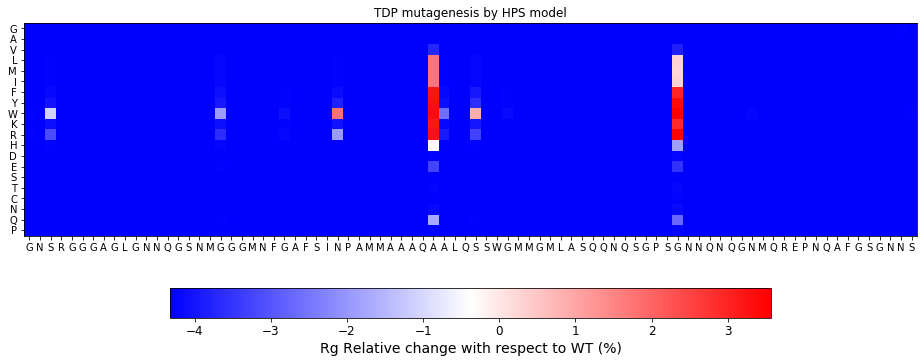

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(figsize=(16,12))

seq='GNSRGGGAGLGNNQGSNMGGGMNFGAFSINPAMMAAAQAALQSSWGMMGMLASQQNQSGPSGNNQNQGNMQREPNQAFGSGNNS'
mutations='GAVLMIFYWKRHDESTCNQP'
og_rg = 55.961294137572565
data = pd.read_csv('/home/adria/TDPrewSCALE.txt', sep=" ", header=None)
rgs = data[2].values
neffs = data[3].values

rg_masked = rgs.copy()
# rg_masked[np.where(neffs<0.1)] = np.nan
r2 = 100*(rg_masked.reshape(len(seq), len(mutations)).T - og_rg)/og_rg

cmap = matplotlib.cm.get_cmap('bwr')
cmap.set_bad('black', alpha=0.4)
# img = ax.imshow(r2, cmap=cmap, vmin=-3, vmax=3)
img = ax.imshow(r2, cmap=cmap)


ax.set_title("TDP mutagenesis by HPS model")
ax.set_xticks(range(len(seq)))
ax.set_yticks(range(len(mutations)))
ax.set_yticklabels(list(mutations));
ax.set_xticklabels(list(seq));
ax.set_ylim(r2.shape[0]-0.5, -0.5)
cb = plt.colorbar(img, orientation='horizontal', fraction=0.046, pad=0.08)
cb.set_label("Rg Relative change with respect to WT (%)", fontsize=14)
cb.ax.tick_params(labelsize=12)